# Evaluation of the finetuned model checkpoints

This is a simplified version of the evaluation notebook, without charts, just running all checkpoints and saving the results.

In [1]:
!pip install -q transformers datasets torch unsloth ipywidgets scikit-learn numpy plotly pandas matplotlib hf_transfer natsort
import os
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Loading the dataset:

In [2]:
from datasets import load_dataset

dataset = load_dataset("RoBiology/RoBiologyDataChoiceQA")
dataset

DatasetDict({
    train: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 11368
    })
    validation: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 1376
    })
    test: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 1388
    })
})

In [3]:
test_ds = dataset['test'].filter(lambda x: x['type'] == 'single-choice')
test_ds

Dataset({
    features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
    num_rows: 588
})

Setup storage location:

In [4]:
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    drive.mount('/content/drive')
    DRIVE_MOUNTED = True
except Exception:
    DRIVE_MOUNTED = False

if not IN_COLAB:
    final_model_path = './lora_model'
    checkpoints_path = './checkpoints'
else:
    if DRIVE_MOUNTED:
        final_model_path = '/content/drive/MyDrive/Colab Notebooks/finetuning/lora_model'
        checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/finetuning/checkpoints'
    else:
        raise Exception("Drive not mounted")

Setting up the input for the model:

Load tokenizer:

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(final_model_path)

In [6]:
def create_chat_prompt(instruction: str, input: str, response: str|None = None):
    return tokenizer.apply_chat_template(
        [
            {"role": "system", "content": instruction},
            {"role": "user", "content": input},
            *([{"role": "assistant", "content": response}] if response else []),
        ],
        tokenize=False,
        add_generation_prompt=True,
    )

In [7]:
instuction = "Answer the question based on the given options. Respond by writing only the letter of the correct answer."

print(create_chat_prompt(
    instuction,
    "\n".join([test_ds[0]["question"]] + test_ds[0]["options"]),
    # test_ds[0]["right_answer"],
))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 07 Dec 2024

Answer the question based on the given options. Respond by writing only the letter of the correct answer.<|eot_id|><|start_header_id|>user<|end_header_id|>

Următorul reflex este monosinaptic:
A. rotulian
B. cardioaccelerator
C. de apărare
D. vasoconstrictor<|eot_id|><|start_header_id|>assistant<|end_header_id|>




Create chat prompts for all test dataset entries:

In [8]:
test_ds = test_ds.map(lambda x: {
    "chat": create_chat_prompt(instuction, '\n'.join([x['question']] + x['options'])) 
})

## Running all checkpoints

Read all checkpoints:

In [9]:
from natsort import natsorted

checkpoints = [os.path.join(checkpoints_path, f) for f in os.listdir(checkpoints_path)]

checkpoints = natsorted(checkpoints)

# if last checkpoint is not the final model, add it
# checkpoints += [final_model_path]

checkpoints

['./checkpoints/checkpoint-100',
 './checkpoints/checkpoint-200',
 './checkpoints/checkpoint-300',
 './checkpoints/checkpoint-400',
 './checkpoints/checkpoint-500',
 './checkpoints/checkpoint-600',
 './checkpoints/checkpoint-700',
 './checkpoints/checkpoint-800',
 './checkpoints/checkpoint-900',
 './checkpoints/checkpoint-1000',
 './checkpoints/checkpoint-1100',
 './checkpoints/checkpoint-1200',
 './checkpoints/checkpoint-1300',
 './checkpoints/checkpoint-1400',
 './checkpoints/checkpoint-1500',
 './checkpoints/checkpoint-1600',
 './checkpoints/checkpoint-1700',
 './checkpoints/checkpoint-1800',
 './checkpoints/checkpoint-1900',
 './checkpoints/checkpoint-2000',
 './checkpoints/checkpoint-2100',
 './checkpoints/checkpoint-2200',
 './checkpoints/checkpoint-2300',
 './checkpoints/checkpoint-2400',
 './checkpoints/checkpoint-2500',
 './checkpoints/checkpoint-2600',
 './checkpoints/checkpoint-2700',
 './checkpoints/checkpoint-2800',
 './checkpoints/checkpoint-2900',
 './checkpoints/checkpo

Test all the checkpoints models:

In [10]:
from tqdm.notebook import tqdm
import torch
import gc
from unsloth import FastLanguageModel
from transformers import AutoModelForCausalLM
from IPython.display import clear_output, display
from IPython.utils.capture import capture_output


def test_model(model, seed=42, do_sample=False, temperature=0):
    answers = []

    for entry in tqdm(test_ds):
        # set seed
        torch.manual_seed(seed)

        # tokenize
        input = tokenizer(
            entry["chat"],
            return_tensors="pt",
        ).to(model.device)

        # generate and return sequence, scores and logits, with given temperature and sampling
        response = model.generate(
            **input,
            max_new_tokens=1,
            do_sample=do_sample,
            temperature=temperature,
            return_dict_in_generate=True,
            output_scores=True,
            output_logits=True,
            pad_token_id=tokenizer.eos_token_id,
        )

        # decode answer
        output = tokenizer.decode(
            response["sequences"][0][input.input_ids.shape[1] :],
            skip_special_tokens=True,
        ).strip()

        # get top 10 tokens and scores
        scores = response["scores"][0]
        top_k = scores.topk(10)
        top_k_tokens = tokenizer.convert_ids_to_tokens(top_k.indices.reshape(-1, 1))

        # append to answers
        answers.append(
            {
                "pred": output,
                "top_k_tokens": top_k_tokens,
                "top_k_scores": top_k.values.tolist()[0],
            }
        )

    return answers

checkpoints_answers = []

for checkpoint in tqdm(checkpoints, desc='Running checkpoints'):

    print(checkpoint)
    
    # prevent output from being displayed in the cell's output
    with capture_output() as captured:
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name = checkpoint,
            max_seq_length = 2048,
            dtype = None,
            load_in_4bit = False,
        )
        FastLanguageModel.for_inference(model)
        # model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map='cuda')
        

    with torch.no_grad():
        answers = test_model(model)
        checkpoints_answers.append(answers)


    del model

    for _ in range(3):
        for gc_step in range(3):
            gc.collect(gc_step)
            torch.cuda.empty_cache()


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Running checkpoints:   0%|          | 0/31 [00:00<?, ?it/s]

./checkpoints/checkpoint-100


Unsloth 2024.12.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


  0%|          | 0/588 [00:00<?, ?it/s]

./checkpoints/checkpoint-200


  0%|          | 0/588 [00:00<?, ?it/s]

./checkpoints/checkpoint-300


  0%|          | 0/588 [00:00<?, ?it/s]

./checkpoints/checkpoint-400


  0%|          | 0/588 [00:00<?, ?it/s]

./checkpoints/checkpoint-500


  0%|          | 0/588 [00:00<?, ?it/s]

./checkpoints/checkpoint-600


## Process results

Merge test dataset with answers:

In [12]:
import pandas as pd
test_df = pd.DataFrame(test_ds)

all_answers_df = []
for answers, checkpoint in zip(checkpoints_answers, checkpoints):
    answers_df=pd.DataFrame(answers).rename(columns={'output': 'pred'})
    answers_df = test_df.join(answers_df)
    answers_df['checkpoint'] = checkpoint
    all_answers_df.append(answers_df)

all_answers_df = pd.concat(all_answers_df)
all_answers_df


,question_number,question,type,options,grade,stage,year,right_answer,source,id_in_source,dupe_id,chat,pred,top_k_tokens,top_k_scores,checkpoint
0,30,Următorul reflex este monosinaptic:,single-choice,"[A. rotulian, B. cardioaccelerator, C. de apăr...",VII,locala,2018,A,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,A,"[A, D, B, C, E, R, V, U, M, S]","[31.625, 31.5, 31.5, 31.5, 23.25, 22.125, 21.6...",./checkpoints/checkpoint-100
1,25,Axonii neuronilor olfactivi străbat lama ciuru...,single-choice,"[A. etmoid, B. sfenoid, C. zigomatic, D. frontal]",VII,locala,2018,A,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,A,"[A, B, C, D, E, S, F, R, T, L]","[32.25, 31.875, 31.0, 31.0, 24.625, 21.75, 21....",./checkpoints/checkpoint-100
2,24,Astigmatismul:,single-choice,[A. este un defect care nu afectează sistemul ...,VII,locala,2018,C,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,C,"[C, D, B, A, E, R, CD, BC, AC, AB]","[32.75, 31.625, 31.625, 31.125, 22.5, 22.125, ...",./checkpoints/checkpoint-100
3,22,Structuri bogat vascularizate sunt:,single-choice,"[A. coroida, dermul, B. corneea, mucoasa nazal...",VII,locala,2018,A,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,D,"[D, C, A, B, E, R, S, P, V, Cor]","[32.25, 31.625, 31.625, 31.375, 23.625, 21.75,...",./checkpoints/checkpoint-100
4,20,Arcul reflex:,single-choice,"[A. este format din 3 componente, B. reprezint...",VII,locala,2018,B,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,D,"[D, B, C, A, CD, E, R, BC, AC, AD]","[32.5, 31.625, 31.375, 31.125, 22.5, 22.5, 22....",./checkpoints/checkpoint-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,39,Glicoliza anaerobă se caracterizează prin urmă...,single-choice,"[A. randament foarte ridicat, B. transformarea...",facultate,admitere,2020,A,UMF Brasov,metabolismul/varianta_B,None,<|begin_of_text|><|start_header_id|>system<|en...,C,"[C, E, B, D, A, CE, F, BC, G, M]","[36.75, 32.25, 30.5, 28.75, 26.5, 25.75, 24.25...",./lora_model
584,1,Alegeți afirmația incorectă referitoare la aci...,single-choice,[A. prin reacția de beta-oxidare duc la formar...,facultate,admitere,2020,C,UMF Brasov,metabolismul/varianta_B,None,<|begin_of_text|><|start_header_id|>system<|en...,D,"[D, E, C, A, B, DE, AD, ADE, ED, AB]","[34.25, 32.25, 31.125, 30.25, 28.375, 27.125, ...",./lora_model
585,21,Care dintre următorii hormoni au rol predomina...,single-choice,"[A. hormonul somatotrop, B. testosteronul, C. ...",facultate,admitere,2020,C,UMF Brasov,metabolismul/varianta_A,None,<|begin_of_text|><|start_header_id|>system<|en...,C,"[C, B, A, D, E, F, G, P, M, H]","[39.25, 31.25, 30.125, 29.125, 29.0, 27.0, 25....",./lora_model
586,11,Despre rolurile lipidelor în organism nu se po...,single-choice,[A. lipidele aflate în organism reprezintă o r...,facultate,admitere,2020,A,UMF Brasov,metabolismul/varianta_A,None,<|begin_of_text|><|start_header_id|>system<|en...,E,"[E, C, B, A, D, CE, BC, AE, AB, BE]","[34.75, 32.75, 32.5, 29.5, 28.75, 25.75, 24.62...",./lora_model


In [13]:
all_answers_df['correct'] = all_answers_df['right_answer'] == all_answers_df['pred']

In [14]:
stats = []

for checkpoint in all_answers_df['checkpoint'].unique():
    answers_df = all_answers_df[all_answers_df['checkpoint'] == checkpoint]
    stats.append({
        'checkpoint': checkpoint,
        'accuracy': answers_df['correct'].mean(),
    })

stats_df = pd.DataFrame(stats)
stats_df

,checkpoint,accuracy
0,./checkpoints/checkpoint-100,0.382653
1,./checkpoints/checkpoint-200,0.392857
2,./checkpoints/checkpoint-300,0.375850
3,./checkpoints/checkpoint-400,0.408163
4,./checkpoints/checkpoint-500,0.437075
5,./checkpoints/checkpoint-600,0.404762
6,./checkpoints/checkpoint-700,0.442177
7,./checkpoints/checkpoint-800,0.418367
8,./checkpoints/checkpoint-900,0.425170
9,./checkpoints/checkpoint-1000,0.401361


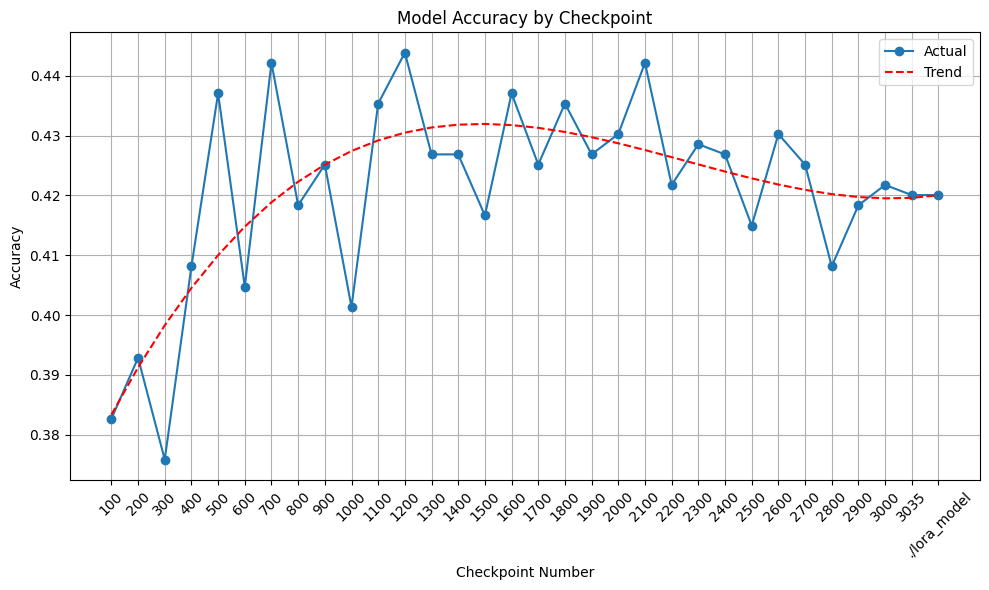

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Plot original data points
x = np.array(range(len(stats_df)))
y = stats_df['accuracy'].values
plt.plot(x, y, marker='o', label='Actual')

# Fit and plot polynomial trendline
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
plt.plot(x, p(x), 'r--', label='Trend')

plt.title('Model Accuracy by Checkpoint')
plt.xlabel('Checkpoint Number')
plt.ylabel('Accuracy') 
plt.grid(True)
plt.xticks(range(len(stats_df)), [cp.split('-')[-1] for cp in stats_df['checkpoint']], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
